In [13]:
# tar -xvf CommonVoice/Japanese.tar
# tar -xvf CommonVoice/Hindi.tar

import os
import glob
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import Normalize, Resize, imagenet_stats, cnn_learner, error_rate
from tqdm import tqdm

labels = ['hi', 'ja']
language_names = {
    'hi': 'Hindi',
    'ja': 'Japanese'
}

# when you untar the data, it ends up in this folder.
data_path = Path('./cv-corpus-6.1-2020-12-11')

# where the folds are stored. Each fold is a directory containing 1/10th of the data in
# the folder 'valid', and 9/10ths of the data in the folder 'train'
folds_path = data_path/'folds'


In [6]:
# language is the language code (e.g. 'hi' for Hindi, 'ja' for Japanese)
def create_language_spectrograms(language):
    spectrogram_path = data_path/language/'spectrograms'
    if os.path.isdir(spectrogram_path):
        print(f"Directory {spectrogram_path} already exists, skipping spectrogram conversion for {language_names[language]}")
        return
    print(f'Converting audio for {language_names[language]} into spectrograms')
    os.mkdir(spectrogram_path)

    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    for i, audio_file in tqdm(enumerate(list(Path(data_path/language/'clips').glob('*.mp3')))):
        # If you get an error here, you may need to install FFmpeg.
        # FFmpeg is a utility that librosa uses to open mp3 files on some platforms.
        # Make sure that the command line you start your jupyter notebook server in has access to ffmpeg
        samples, sample_rate = librosa.load(audio_file)
        filename = spectrogram_path/Path(audio_file).name.replace('.mp3','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close('all')
    
def setup_fold_directories():
    if (os.path.isdir(folds_path)):
        print(f"Directory {folds_path} already exists, skipping setup of directory hierarchy.")
        return
    # create folders for each fold
    os.mkdir(folds_path)
    for fold_num in range(1, 11):
        fold = str(fold_num)
        os.mkdir(folds_path/fold)
        os.mkdir(folds_path/fold/'train')
        os.mkdir(folds_path/fold/'valid')
        for label in labels:
            os.mkdir(folds_path/fold/'train'/label)
            os.mkdir(folds_path/fold/'valid'/label)
    return
 
def partition_into_folds(language):
    print(f'Partitioning spectrograms for {language_names[language]} into folds')
    spectrogram_path = data_path/language/'spectrograms'
    png_files = list(spectrogram_path.glob('*.png'))

    for file_num, file in tqdm(enumerate(png_files)):
        # this is the fold for which this file is in the validation set
        valid_fold_num = file_num % 10 + 1
        for fold_num in range(1, 11):
            fold = str(fold_num)
            if fold_num == valid_fold_num:
                shutil.copyfile(file, folds_path/fold/'valid'/language/file.name)
            else:
                shutil.copyfile(file, folds_path/fold/'train'/language/file.name)

setup_fold_directories()
create_language_spectrograms('hi')
partition_into_folds('hi')
create_language_spectrograms('ja')
partition_into_folds('ja')


14it [00:00, 123.33it/s]

Directory cv-corpus-6.1-2020-12-11\folds already exists, skipping setup of directory hierarchy.
Directory cv-corpus-6.1-2020-12-11\hi\spectrograms already exists, skipping spectrogram conversion for Hindi
Partitioning spectrograms for Hindi into folds


618it [00:03, 190.67it/s]
10it [00:00, 98.93it/s]

Directory cv-corpus-6.1-2020-12-11\ja\spectrograms already exists, skipping spectrogram conversion for Japanese
Partitioning spectrograms for Japanese into folds


1062it [00:12, 85.96it/s] 


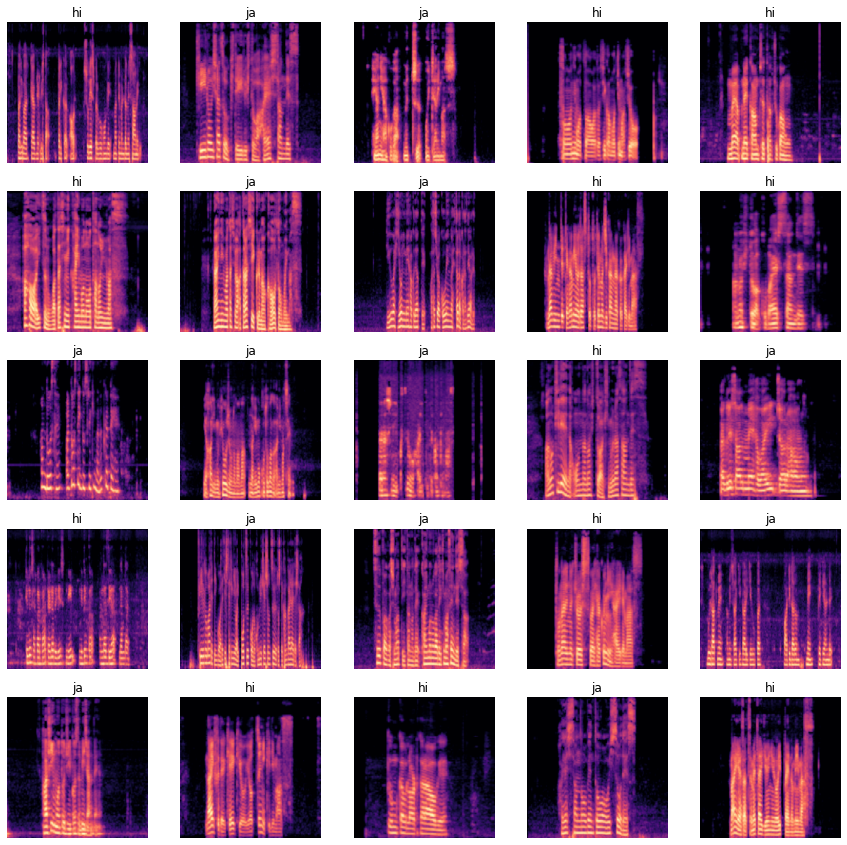

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
# data = ImageDataBunch.from_folder(data_directory/'1', ds_tfms=[], size=224)
# data = ImageDataLoaders.from_folder(data_directory/'1', item_tfms=[Resize(224), Normalize.from_stats(*imagenet_stats)])
data = ImageDataLoaders.from_folder(folds_path/'1', 
                                    item_tfms=Resize(224), 
                                    batch_tfms=Normalize.from_stats(*imagenet_stats))
data.show_batch(max_n=25)

In [14]:
def process_fold(fold):
    data = ImageDataLoaders.from_folder(folds_path/fold, 
                                    item_tfms=Resize(224), 
                                    batch_tfms=Normalize.from_stats(*imagenet_stats),
                                    num_workers=0)
    learn = cnn_learner(data, models.resnet34, metrics=error_rate)
    print(type(learn))
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, lr_max=slice(1e-6,1e-4))

In [15]:
process_fold('1')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,0.997645,0.565993,0.201183,00:20
1,0.648831,0.376498,0.147929,00:10
2,0.477126,0.348134,0.142012,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.346548,0.639737,0.082840,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.143650,0.177709,0.041420,00:12
1,0.134746,0.145241,0.029586,00:12
2,0.121399,0.150702,0.029586,00:12


In [16]:
process_fold('2')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,0.983793,0.324532,0.165680,00:17
1,0.694058,0.248418,0.094675,00:10
2,0.518329,0.238618,0.094675,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.441692,0.985509,0.130178,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.175956,0.238609,0.059172,00:12
1,0.149886,0.186505,0.053254,00:12
2,0.129089,0.169806,0.059172,00:12


In [17]:
process_fold('3')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,0.901679,0.489974,0.220238,00:17
1,0.615926,0.412705,0.166667,00:10
2,0.468638,0.360677,0.136905,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.341648,0.892477,0.184524,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.129986,0.276213,0.077381,00:12
1,0.115989,0.238864,0.071429,00:12
2,0.098496,0.230050,0.065476,00:12


In [18]:
process_fold('4')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,0.925140,0.365317,0.119048,00:16
1,0.628873,0.288273,0.083333,00:10
2,0.469057,0.262713,0.071429,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.338530,0.248737,0.059524,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.105256,0.088505,0.035714,00:12
1,0.105980,0.067244,0.023810,00:12
2,0.095423,0.067129,0.017857,00:12


In [19]:
process_fold('5')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,0.944776,0.515073,0.202381,00:17
1,0.655868,0.269117,0.130952,00:10
2,0.497392,0.258705,0.130952,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.311728,0.246906,0.053571,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.122846,0.071870,0.017857,00:12
1,0.116484,0.059367,0.011905,00:12
2,0.110274,0.057473,0.011905,00:12


In [20]:
process_fold('6')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,0.857834,0.463373,0.172619,00:16
1,0.618632,0.297123,0.113095,00:10
2,0.483409,0.291515,0.107143,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.397666,0.154531,0.059524,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.144032,0.111001,0.035714,00:12
1,0.116516,0.103618,0.029762,00:12
2,0.103820,0.102844,0.029762,00:12


In [21]:
process_fold('7')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,0.886887,0.347705,0.136905,00:17
1,0.605167,0.278337,0.083333,00:10
2,0.461869,0.239914,0.077381,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.385793,1.321254,0.196429,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.162663,0.219662,0.065476,00:12
1,0.148344,0.175493,0.059524,00:12
2,0.130625,0.172365,0.059524,00:12


In [22]:
process_fold('8')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,0.949603,0.387047,0.119048,00:17
1,0.647293,0.301455,0.101190,00:10
2,0.451644,0.277452,0.089286,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.417464,0.746292,0.095238,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.187222,0.100634,0.029762,00:12
1,0.145031,0.069359,0.029762,00:12
2,0.125023,0.082192,0.029762,00:12


In [23]:
process_fold('9')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,0.840153,0.538741,0.197605,00:17
1,0.591421,0.380542,0.155689,00:10
2,0.452571,0.339824,0.125749,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.398263,0.485766,0.101796,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.145942,0.222416,0.059880,00:12
1,0.116797,0.210241,0.053892,00:12
2,0.106199,0.205529,0.053892,00:12


In [24]:
process_fold('10')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,0.945389,0.363355,0.149701,00:17
1,0.635597,0.237080,0.107784,00:11
2,0.483687,0.227102,0.107784,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.327361,0.776446,0.221557,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.135588,0.113635,0.035928,00:12
1,0.113609,0.076143,0.017964,00:12
2,0.092618,0.072920,0.017964,00:12


In [26]:
error_rates = [0.029586, 0.059172, 0.065476, 0.017857, 0.011905, 0.029762, 0.059524, 0.029762, 0.053892, 0.017964]
accuracy = 1 - sum(error_rates) / 10
print(f"Overall accuracy is {accuracy * 100}%")

Overall accuracy is 96.251%
